In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#For random forest for time series:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster

#For metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.feature_selection import RFE

#For multiprocessing further down
import multiprocessing

#For timing stuff
import time


#Having to import from subfolders of parent directories is a nightmare
import sys
import os
current = os.path.dirname(os.path.realpath("Random-Forest-Hyperparameter-Tuning-Prod-V2.py"))
parent = os.path.dirname(current)
parent2 = os.path.dirname(parent)
sys.path.append(parent2+"\Functions")

#From Functions folder
from LoadSeries import load_series, moving_average

In [2]:
num_cores = multiprocessing.cpu_count()
print(num_cores)

num_cores = num_cores//2

4


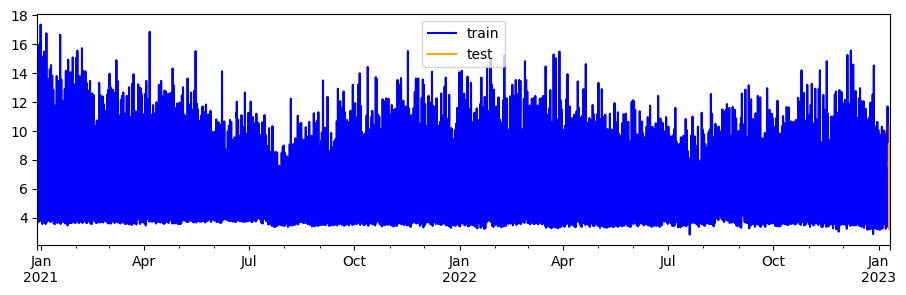

,val,val-24,val-48,val-168,Year,Month,Day,Weekday,Hour
2020-12-29 00:00:00,5.7,5.7,6.9,6.3,2020,12,29,1,0
2020-12-29 01:00:00,5.9,5.4,5.3,4.8,2020,12,29,1,1
2020-12-29 02:00:00,5.0,6.0,4.9,4.8,2020,12,29,1,2
2020-12-29 03:00:00,3.9,6.8,4.4,4.3,2020,12,29,1,3
2020-12-29 04:00:00,3.5,4.0,3.6,4.0,2020,12,29,1,4
...,...,...,...,...,...,...,...,...,...
2023-01-10 16:00:00,6.1,7.6,6.9,5.4,2023,1,10,1,16
2023-01-10 17:00:00,8.3,10.0,9.8,6.2,2023,1,10,1,17
2023-01-10 18:00:00,10.4,9.1,14.5,13.0,2023,1,10,1,18
2023-01-10 19:00:00,9.9,11.1,10.8,10.4,2023,1,10,1,19


In [3]:
train_series = load_series("c","h16","val", [24,48,168])

train = train_series[:-24]
test = train_series[-24:]

fig, ax=plt.subplots(figsize=(11, 3))
moving_average(train['val'], 3).plot(ax=ax, label='train', color='blue')
moving_average(test['val'], 1).plot(ax=ax, label='test', color='orange')
ax.legend();
plt.show()
train_series

## Setup

In [4]:
#For hyperparameter tuning
N_train     = 24
Start_train = "2021-06-19 00:00:00"
End_train   = pd.date_range(start=Start_train, periods=N_train, freq="h")[-1]

#For predicting
N     = 24*7
Start = "2022-06-19 00:00:00"
End   = pd.date_range(start=Start, periods=N, freq="h")[-1]

bootstrap = True
if bootstrap:
    interval = [5/2, 100-5/2]
    n_boot   = 5

else:
    interval = None
    n_boot   = None

#For both
stepsize      = 2
train_sizes   = [100,500,1000,2000,3000,4000]
Before_trains = [pd.date_range(end=Start_train, periods=train_size+1, freq="h")[0] for train_size in train_sizes]
Befores       = [pd.date_range(end=Start, periods=train_size+1, freq="h")[0] for train_size in train_sizes]


################################################################################################################################
#Hyper parameter tuning setup
################################################################################################################################

# Lags used as predictors (defined above)
lags_grid = [1,6,12,18,24]
# Regressor's hyperparameters

use_scikit = True

if not use_scikit:
    def search_space(trial):
        search_space  = {'n_estimators' : trial.suggest_int('n_estimators', 2, 1000),
                         'max_depth'    : trial.suggest_int('max_depth', 1, 15),
                         'max_features' : trial.suggest_categorical('max_features', ['log2', 'sqrt'])
                        } 
        return search_space

else:
    from skopt.space import Categorical, Real, Integer
    search_space = {'n_estimators' : Integer(2, 1000, "uniform", name='n_estimators'),
                    'max_depth'    : Integer(1, 20, "uniform", name='max_depth'),
                    'max_features' : Categorical(['log2', 'sqrt'], name='max_features')
                   }

## Hyperparameter tuning

In [5]:
print(f"Predicting from {Start_train} to {End_train}")

start = time.time()
results_i = []
metrics   = []
for i in range(len(train_sizes)):
    #Initialize
    forecaster = ForecasterAutoreg(
                    regressor = RandomForestRegressor(random_state=123,n_jobs=num_cores),
                    lags      = 1 # This value will be replaced in the grid search
                 )
    
    train_size   = train_sizes[i]
    Before_train = Before_trains[i]
    
    #Tune
    results, frozen_trial = bayesian_search_forecaster(
                                forecaster         = forecaster,
                                y                  = train_series.loc[Before_train:End_train]['val'],
                                exog               = train_series.loc[Before_train:End_train].drop(['val'], axis=1),
                                lags_grid          = lags_grid,
                                search_space       = search_space,
                                steps              = 24,
                                metric             = 'mean_squared_error',
                                refit              = True,
                                initial_train_size = train_size,
                                fixed_train_size   = True,
                                n_trials           = 10,
                                random_state       = 123,
                                return_best        = True,
                                verbose            = False,
                                engine             = 'skopt',
                                kwargs_gp_minimize = {}
                            )
    end = time.time()
    print("Time spent so far {}s".format(end-start))
    metric = results.mean_squared_error.to_numpy()[0]
    argmin = results.mean_squared_error.index.to_numpy()[0]
    metrics.append(metric)
    results_i.append(results.loc[argmin])

Predicting from 2021-06-19 00:00:00 to 2021-06-19 23:00:00
Number of models compared: 50,
         10 bayesian search in each lag configuration.


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [02:57<00:00, 35.52s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6] 
  Parameters: {'n_estimators': 720, 'max_depth': 10, 'max_features': 'sqrt'}
  Backtesting metric: 0.6590278225637086

Time spent so far 179.02174830436707s
Number of models compared: 50,
         10 bayesian search in each lag configuration.


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [03:02<00:00, 36.42s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'n_estimators': 633, 'max_depth': 9, 'max_features': 'log2'}
  Backtesting metric: 0.6018989795734946

Time spent so far 362.5789632797241s
Number of models compared: 50,
         10 bayesian search in each lag configuration.


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [03:12<00:00, 38.47s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6] 
  Parameters: {'n_estimators': 412, 'max_depth': 12, 'max_features': 'log2'}
  Backtesting metric: 0.6219256858438732

Time spent so far 556.0846717357635s
Number of models compared: 50,
         10 bayesian search in each lag configuration.


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [03:47<00:00, 45.41s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6] 
  Parameters: {'n_estimators': 246, 'max_depth': 14, 'max_features': 'sqrt'}
  Backtesting metric: 0.7790395625743343

Time spent so far 784.1123547554016s
Number of models compared: 50,
         10 bayesian search in each lag configuration.


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [04:06<00:00, 49.25s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1] 
  Parameters: {'n_estimators': 236, 'max_depth': 20, 'max_features': 'sqrt'}
  Backtesting metric: 0.8846746213246215

Time spent so far 1031.5733978748322s
Number of models compared: 50,
         10 bayesian search in each lag configuration.


loop lags_grid: 100%|███████████████████████████████████████| 5/5 [04:24<00:00, 52.94s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1] 
  Parameters: {'n_estimators': 236, 'max_depth': 20, 'max_features': 'sqrt'}
  Backtesting metric: 0.9227435577313482

Time spent so far 1297.7442903518677s


In [6]:
i=np.argmin(metrics)
best = results_i[i]
print(best.lags)
print(best.params)

forecaster = ForecasterAutoreg(
                    regressor = RandomForestRegressor(random_state=123,n_jobs=num_cores,**best.params),
                    lags      = best.lags # This value will be replaced in the grid search
                 )

Before = Befores[i]
train_size = train_sizes[i]

[ 1  2  3  4  5  6  7  8  9 10 11 12]
{'n_estimators': 633, 'max_depth': 9, 'max_features': 'log2'}


## Predicting stepsize amount at a time (like in single house opt)

In [7]:
print(f"Predicting from {Start} to {End}")

preds = pd.DataFrame() 

start = time.time()
for i in range(N//stepsize):#stepsize has to be even
    _, predictions = backtesting_forecaster(
                        forecaster         = forecaster,
                        y                  = train_series.loc[Before:End].iloc[i*stepsize:train_size+(i+1)*stepsize]['val'],
                        exog               = train_series.loc[Before:End].iloc[i*stepsize:train_size+(i+1)*stepsize].drop(['val'], axis=1),
                        initial_train_size = train_size,
                        steps              = stepsize,
                        refit              = True,
                        interval           = interval,
                        n_boot             = n_boot,
                        metric             = 'mean_squared_error',
                        fixed_train_size   = True,
                        verbose            = False
                     )
    preds=pd.concat([preds,predictions])
    
end = time.time()
print("Training took {}s".format(end-start))
preds

Predicting from 2022-06-19 00:00:00 to 2022-06-25 23:00:00
Training took 245.93737530708313s


,pred,lower_bound,upper_bound
2022-06-19 00:00:00,6.917393,6.416553,7.606584
2022-06-19 01:00:00,6.519556,5.848908,6.763016
2022-06-19 02:00:00,4.908921,4.487222,5.811953
2022-06-19 03:00:00,4.078161,2.965920,5.297929
2022-06-19 04:00:00,3.739996,3.292069,4.433396
...,...,...,...
2022-06-25 19:00:00,9.675157,9.408874,9.781765
2022-06-25 20:00:00,8.521125,8.026409,8.651893
2022-06-25 21:00:00,7.911242,7.420679,7.915541
2022-06-25 22:00:00,7.455517,7.211372,8.383813


In [8]:
preds.to_csv("preds.csv")
results.to_csv("results.csv")
predictions =  pd.read_csv("preds.csv")
results_grid = pd.read_csv("results.csv")
predictions = predictions.rename(columns={"Unnamed: 0": "Time"}, errors="raise")

if bootstrap:
    predictions = predictions[["Time","pred","lower_bound","upper_bound"]]
else:
    predictions = predictions[["Time","pred"]]
predictions["Time"] = pd.to_datetime(predictions["Time"])
predictions = predictions.set_index("Time").sort_index()
predictions.index = pd.date_range(start=predictions.index[0], end=predictions.index[-1], freq="h")

predictions.head(4)

,pred,lower_bound,upper_bound
2022-06-19 00:00:00,6.917393,6.416553,7.606584
2022-06-19 01:00:00,6.519556,5.848908,6.763016
2022-06-19 02:00:00,4.908921,4.487222,5.811953
2022-06-19 03:00:00,4.078161,2.965920,5.297929


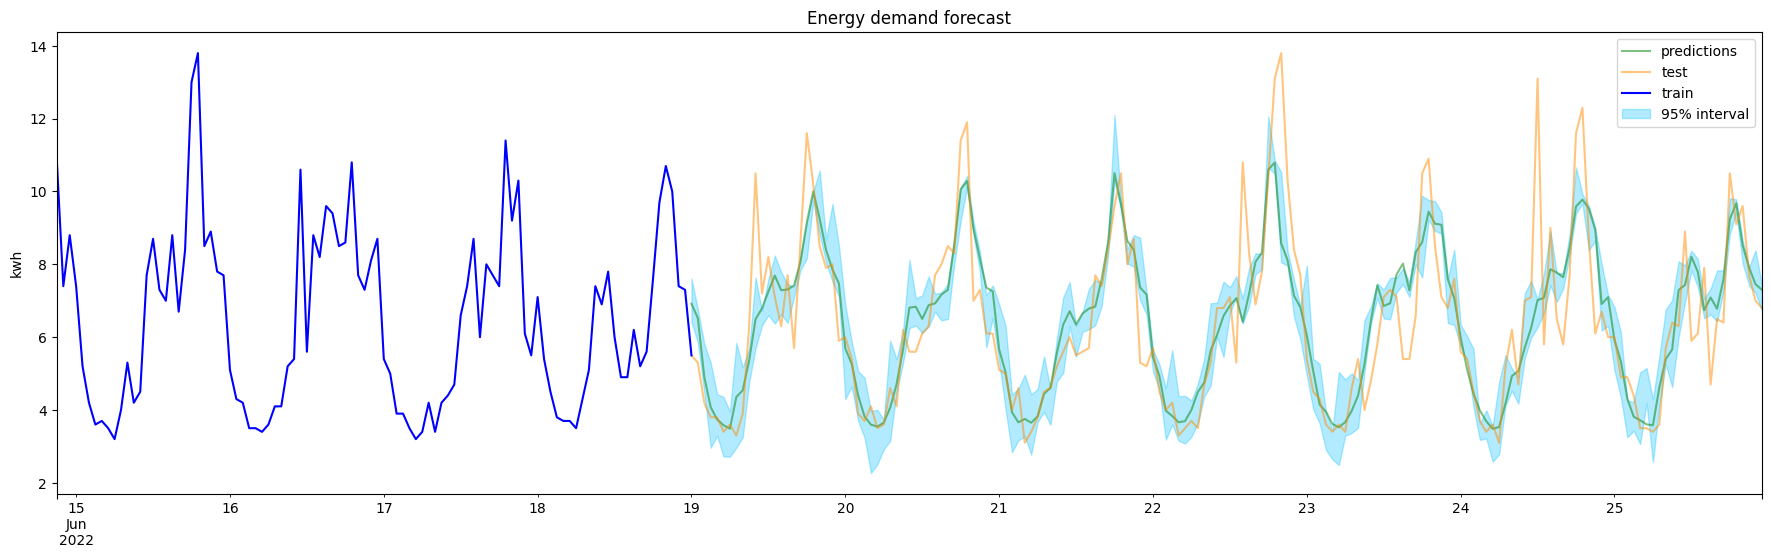

In [9]:
fig, ax=plt.subplots(figsize=(22, 6))
predictions['pred'].plot(ax=ax, label='predictions', color="green",alpha=0.5)
train_series.loc[Start:End]['val'].plot(ax=ax, label='test', color="darkorange", alpha=0.5)
train_series.loc[Before:Start].iloc[-100:]['val'].plot(ax=ax, label='train', color="blue")
if bootstrap:
    ax.fill_between(
        predictions.index,
        predictions['lower_bound'],
        predictions['upper_bound'],
        color = 'deepskyblue',
        alpha = 0.3,
        label = '95% interval'
    )
#ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.set_ylabel('kwh')
ax.set_title('Energy demand forecast')
ax.legend();

In [10]:
error_mse = mean_squared_error(
                y_true = train_series.loc[Start:End]['val'],
                y_pred = predictions['pred']
            )

print(f"Test error (mse): {error_mse}")

inside_interval = np.where(
                     (train_series.loc[predictions.index, 'val'] >= predictions['lower_bound']) & \
                     (train_series.loc[predictions.index, 'val'] <= predictions['upper_bound']),
                     True,
                     False
                  )

coverage = inside_interval.mean()
print(f"Coverage of the predicted interval on test data: {100 * coverage}%")

Test error (mse): 1.630896568301544
Coverage of the predicted interval on test data: 42.26190476190476%


In [11]:
naive_model = np.zeros((len(predictions)))

naive_mse = mean_squared_error(
                y_true = train_series.loc[Start:End]['val'],
                y_pred = naive_model
            )
print(f"Test error (mse): {naive_mse}")

better = error_mse/naive_mse

print(f"RF model only has: {better*100}% of the error that this naive model has")

Test error (mse): 45.84541666665771
RF model only has: 3.5573819301497513% of the error that this naive model has


In [12]:
s = pd.date_range(end=Start, periods=24*7, freq="h")[0]
e = pd.date_range(end=End, periods=24*7, freq="h")[0]
naive_model2 = train_series.loc[s:e]
naive_model2.index = train_series.loc[Start:End].index

naive_mse2 = mean_squared_error(
                y_true = train_series.loc[Start:End]['val'],
                y_pred = naive_model2['val']
            )
print(f"Test error (mse): {naive_mse2}")

better2 = error_mse/naive_mse2

print(f"RF model only has: {better2*100}% of the error that this naive model has")

Test error (mse): 2.727142857135054
RF model only has: 59.80238857068346% of the error that this naive model has


## Predicting 24 hours at a time

In [13]:
print(f"Predicting from {Start} to {End}")

preds = pd.DataFrame() 

start = time.time()
for i in range(N//24):#stepsize has to be even
    _, predictions = backtesting_forecaster(
                        forecaster         = forecaster,
                        y                  = train_series.loc[Before:End].iloc[i*24:train_size+(i+1)*24]['val'],
                        exog               = train_series.loc[Before:End].iloc[i*24:train_size+(i+1)*24].drop(['val'], axis=1),
                        initial_train_size = train_size,
                        steps              = 24,
                        refit              = True,
                        interval           = interval,
                        n_boot             = n_boot,
                        metric             = 'mean_squared_error',
                        fixed_train_size   = True,
                        verbose            = False
                     )
    preds=pd.concat([preds,predictions])
    
end = time.time()
print("Training took {}s".format(end-start))
preds

Predicting from 2022-06-19 00:00:00 to 2022-06-25 23:00:00
Training took 140.2874596118927s


,pred,lower_bound,upper_bound
2022-06-19 00:00:00,6.917393,6.416553,7.606584
2022-06-19 01:00:00,6.519556,5.848908,6.763016
2022-06-19 02:00:00,5.305678,4.917432,5.379624
2022-06-19 03:00:00,4.261751,3.500902,4.761812
2022-06-19 04:00:00,3.937663,2.783005,5.623026
...,...,...,...
2022-06-25 19:00:00,9.783494,9.231389,10.494492
2022-06-25 20:00:00,8.391245,7.635894,8.961866
2022-06-25 21:00:00,7.659357,6.852590,7.562145
2022-06-25 22:00:00,7.257272,6.391035,7.642237


In [14]:
preds.to_csv("preds.csv")
results.to_csv("results.csv")
predictions =  pd.read_csv("preds.csv")
results_grid = pd.read_csv("results.csv")
predictions = predictions.rename(columns={"Unnamed: 0": "Time"}, errors="raise")

if bootstrap:
    predictions = predictions[["Time","pred","lower_bound","upper_bound"]]
else:
    predictions = predictions[["Time","pred"]]
predictions["Time"] = pd.to_datetime(predictions["Time"])
predictions = predictions.set_index("Time").sort_index()
predictions.index = pd.date_range(start=predictions.index[0], end=predictions.index[-1], freq="h")

predictions.head(4)

,pred,lower_bound,upper_bound
2022-06-19 00:00:00,6.917393,6.416553,7.606584
2022-06-19 01:00:00,6.519556,5.848908,6.763016
2022-06-19 02:00:00,5.305678,4.917432,5.379624
2022-06-19 03:00:00,4.261751,3.500902,4.761812


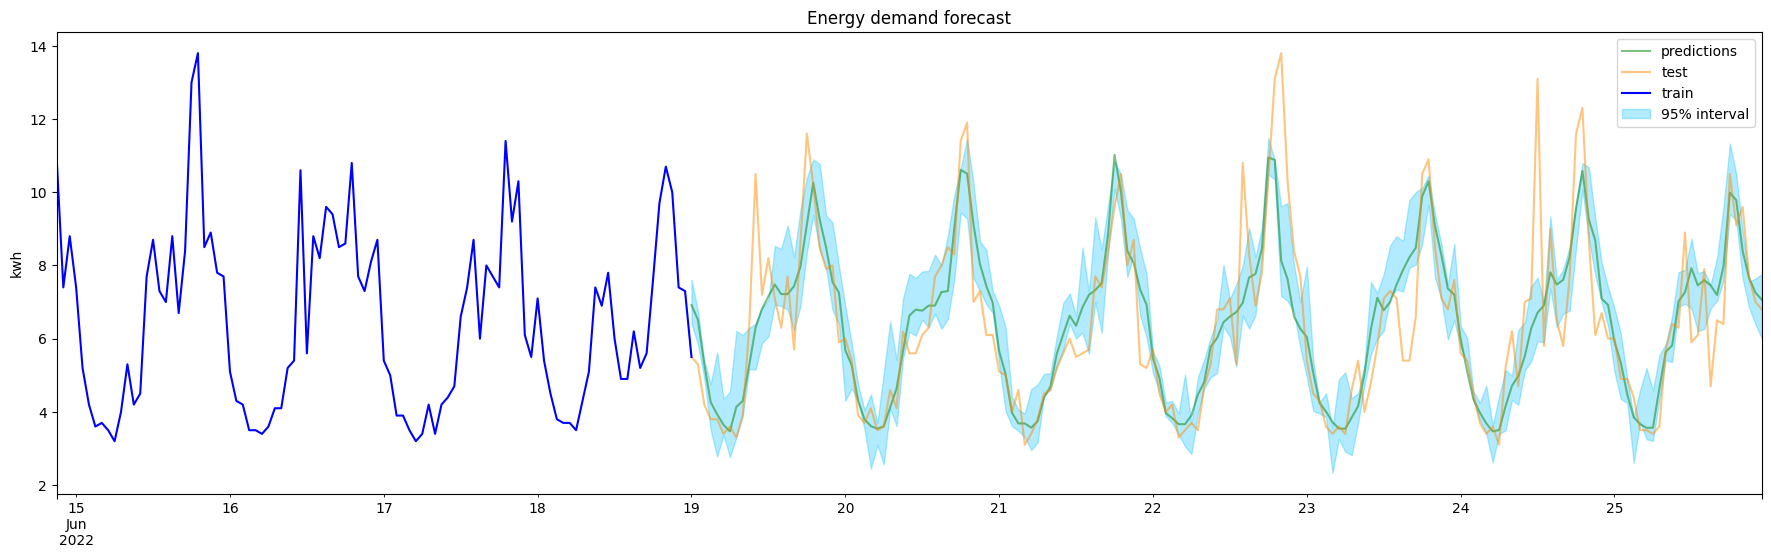

In [15]:
fig, ax=plt.subplots(figsize=(22, 6))
predictions['pred'].plot(ax=ax, label='predictions', color="green",alpha=0.5)
train_series.loc[Start:End]['val'].plot(ax=ax, label='test', color="darkorange", alpha=0.5)
train_series.loc[Before:Start].iloc[-100:]['val'].plot(ax=ax, label='train', color="blue")
if bootstrap:
    ax.fill_between(
        predictions.index,
        predictions['lower_bound'],
        predictions['upper_bound'],
        color = 'deepskyblue',
        alpha = 0.3,
        label = '95% interval'
    )
#ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.set_ylabel('kwh')
ax.set_title('Energy demand forecast')
ax.legend();

In [16]:
error_mse = mean_squared_error(
                y_true = train_series.loc[Start:End]['val'],
                y_pred = predictions['pred']
            )

print(f"Test error (mse): {error_mse}")

inside_interval = np.where(
                     (train_series.loc[predictions.index, 'val'] >= predictions['lower_bound']) & \
                     (train_series.loc[predictions.index, 'val'] <= predictions['upper_bound']),
                     True,
                     False
                  )

coverage = inside_interval.mean()
print(f"Coverage of the predicted interval on test data: {100 * coverage}%")

Test error (mse): 1.6005426557378446
Coverage of the predicted interval on test data: 42.857142857142854%


In [17]:
naive_model = np.zeros((len(predictions)))

naive_mse = mean_squared_error(
                y_true = train_series.loc[Start:End]['val'],
                y_pred = naive_model
            )
print(f"Test error (mse): {naive_mse}")

better = error_mse/naive_mse

print(f"RF model only has: {better*100}% of the error that this naive model has")

Test error (mse): 45.84541666665771
RF model only has: 3.4911726669983163% of the error that this naive model has


In [18]:
s = pd.date_range(end=Start, periods=24*7, freq="h")[0]
e = pd.date_range(end=End, periods=24*7, freq="h")[0]
naive_model2 = train_series.loc[s:e]
naive_model2.index = train_series.loc[Start:End].index

naive_mse2 = mean_squared_error(
                y_true = train_series.loc[Start:End]['val'],
                y_pred = naive_model2['val']
            )
print(f"Test error (mse): {naive_mse2}")

better2 = error_mse/naive_mse2

print(f"RF model only has: {better2*100}% of the error that this naive model has")

Test error (mse): 2.727142857135054
RF model only has: 58.68935877525914% of the error that this naive model has
